In [1]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2023-10-25 04:23:04.953535


## Check for GPU

In [2]:
# Check for GPU
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


## Get helper functions

In [3]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-25 04:25:09--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-25 04:25:09 (62.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Download a text dataset

In [5]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-10-25 04:28:07--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.207, 173.194.210.207, 173.194.212.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2023-10-25 04:28:07 (123 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

In [6]:
# Turn .csv files into pandas DataFrame's
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle w/ random_state=42 for reproduction
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


Inputs (text column) -> ML Algorithm -> Outputs (target column)

In [9]:
# The test data doesn't have a target (that's what we'd try to predict)
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [11]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [13]:
# Let's visualize some random training samples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes, not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
in BOTH 'peacetime and times of national emergency.'

---

Target: 0 (not real disaster)
Text:
Aftershock ã¢ (2010) Fullã¢ Streaming - YouTube http://t.co/vVE3UsesGf

---

Target: 1 (real disaster)
Text:
RÌ©union Debris Is Almost Surely From Flight 370 Officials Say - New York Times http://t.co/gyQLAOz3l2

---

Target: 1 (real disaster)
Text:
Oil and Gas Exploration http://t.co/PckF0nl2yN

---

Target: 0 (not real disaster)
Text:
Riot Kit Bah - part of the new concept Gear coming for Autumn/Winter
#menswear #fashion #urbanfashionÛ_ https://t.co/cCwzDTFbUS

---



### Split data into training and validation sets

In [14]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% fo samples to validation set
                                                                            random_state=42) # random state for reproductibility

In [16]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [17]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

### Text vectorization (tokenization)

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization # after TF 2.6

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [20]:
# Find the average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [21]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in your vocabulary
max_length = 15 # max length our sequence will be (e.g., how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [22]:
# Fit the text vectorization to the training text
text_vectorizer.adapt(train_sentences)

In [23]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [26]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])0

Original text:
We The Free Hailstorm Maxi http://t.co/ERWs6IELdG      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 46,   2, 268, 818,   1,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [27]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

In [28]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of the embedding vector
                             embeddings_initializer="uniform", # default, initialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1")
embedding

In [29]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
#poster #ergo Rotator #cuff injury recovery kit: http://t.co/zj3ODGQHyp Super High Converting Rotator Cuff Inj http://t.co/VZhTiBe4jh      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.03494297, -0.01637463,  0.04855314, ...,  0.01660946,
         -0.02591742,  0.03731659],
        [ 0.04903864, -0.03248235,  0.01607234, ..., -0.00949863,
          0.03786581, -0.00179692],
        [ 0.00475999,  0.01099376,  0.04027177, ..., -0.049888  ,
         -0.02383497, -0.01908834],
        ...,
        [-0.01270777, -0.03789692,  0.03580773, ...,  0.02314693,
         -0.03609834,  0.03805499],
        [ 0.00067522, -0.04929388, -0.02766473, ...,  0.04426893,
          0.00195272, -0.03236183],
        [ 0.03304649, -0.01470693,  0.0092141 , ...,  0.01405745,
          0.03109943, -0.00955176]]], dtype=float32)>

In [30]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 3.49429734e-02, -1.63746253e-02,  4.85531427e-02, -1.51107796e-02,
        3.31138484e-02, -1.63636357e-03,  4.70115878e-02,  1.56398676e-02,
        4.58189100e-03,  4.44633476e-02,  2.78135426e-02,  2.93538608e-02,
        5.47788292e-03, -6.54562563e-03,  1.93672255e-03, -4.66179252e-02,
       -1.50030367e-02, -2.70418525e-02, -2.04884056e-02,  1.36231817e-02,
        4.63757031e-02, -4.75650802e-02,  3.03125717e-02,  2.00905688e-02,
       -2.98481062e-03,  2.51686610e-02,  4.03639562e-02,  2.89984234e-02,
        4.25766967e-02,  4.84744795e-02, -2.89247986e-02, -3.54125127e-02,
        3.02271582e-02, -1.27590522e-02, -3.55666764e-02,  1.54746808e-02,
       -8.80219787e-03,  2.96415351e-02, -1.87678225e-02,  3.02526094e-02,
       -4.87020984e-02, -3.69601734e-02, -1.42225847e-02,  7.41535425e-03,
        1.55859925e-02,  5.05901501e-03, -3.85773405e-02, -2.12088469e-02,
        2.85152458e-02, -5.14409691e-03, -9.43535566

## Modelling a text dataset

### Model 0: Getting a baseline

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [32]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [33]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

In [36]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculate model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  _____
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [37]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model

In [38]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [40]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1, ), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model w/o this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [41]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [42]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [43]:
# Fit the model
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20231025-060003
Epoch 1/5
215/215 [==============================] - 7s 25ms/step - loss: 0.6100 - accuracy: 0.6929 - val_loss: 0.5363 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 7s 34ms/step - loss: 0.4415 - accuracy: 0.8190 - val_loss: 0.4689 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 7s 32ms/step - loss: 0.3466 - accuracy: 0.8608 - val_loss: 0.4585 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 8s 36ms/step - loss: 0.2850 - accuracy: 0.8923 - val_loss: 0.4633 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 9s 42ms/step - loss: 0.2381 - accuracy: 0.9124 - val_loss: 0.4757 - val_accuracy: 0.7861


In [44]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 6ms/step - loss: 0.4757 - accuracy: 0.7861


[0.47570905089378357, 0.7860892415046692]

In [45]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[ 0.01833411, -0.03347163, -0.063764  , ..., -0.0694198 ,
         -0.02054673,  0.03036175],
        [ 0.03558424, -0.02024119,  0.00377649, ...,  0.00888829,
          0.02886869, -0.01118161],
        [ 0.00474999, -0.0332095 , -0.05860901, ..., -0.01303485,
         -0.03522227, -0.02915359],
        ...,
        [ 0.00835592,  0.03019756, -0.04445403, ..., -0.0428058 ,
         -0.009622  ,  0.0206856 ],
        [ 0.0855595 , -0.02690451, -0.02177078, ..., -0.08372704,
         -0.03010788, -0.05626921],
        [ 0.05089844, -0.0386383 , -0.01899816, ..., -0.11055303,
         -0.01944503, -0.10818323]], dtype=float32)>]

In [46]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [ ]:
# # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs \
#   --name "First deep model on text data" \
#   --description "Trying a dense model with an embedding layer" \
#   --one_shot # exits the uploader when upload has finished

In [ ]:
# If you need to remove previous experiments, you can do so using the following command
# !tensorboard dev delete --experiment_id EXPERIMENT_ID_TO_DELETE

Daniel's: https://tensorboard.dev/experiment/5d1Xm10aT6m6MgyW3HAGfw/

In [47]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

24/24 [==============================] - 0s 3ms/step


array([[0.41840243],
       [0.74500096],
       [0.99775225],
       [0.10979894],
       [0.10525218],
       [0.9307355 ],
       [0.90807104],
       [0.992784  ],
       [0.9692676 ],
       [0.26790205]], dtype=float32)

In [48]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimension
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [49]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7903277546022673,
 'recall': 0.7860892388451444,
 'f1': 0.7832971347503846}

In [50]:
# Is our simple Keras model better than our baseline model?
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [51]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.61, Difference: -0.66
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


## Visualizing learned embeddings

In [52]:
# Get the vocabulary from the text vectorization layer
words_in_vocabulary = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [53]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [54]:
# Get the weight matrix of wmbedding layer
# (these are the numerocal patterns bw. the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is an embedding_dim size vector)

(10000, 128)


In [ ]:
# # Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
# import io

# # Create output writers
# out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
# out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# # Write embedding vectors and words to file
# for num, word in enumerate(words_in_vocab):
#   if num == 0:
#      continue # skip padding token
#   vec = embed_weights[num]
#   out_m.write(word + "\n") # write words to file
#   out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
# out_v.close()
# out_m.close()

# # Download files locally to upload to Embedding Projector
# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download("embedding_vectors.tsv")
#   files.download("embedding_metadata.tsv")

## RNNs (Recurrent Neural Networks)

### Model 2: LSTM (Long Short-Term Memory)

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)

In [55]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")

# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [56]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [57]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [59]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20231025-064749
Epoch 1/5
215/215 [==============================] - 13s 49ms/step - loss: 0.5128 - accuracy: 0.7449 - val_loss: 0.4564 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 11s 53ms/step - loss: 0.3183 - accuracy: 0.8727 - val_loss: 0.5137 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 13s 60ms/step - loss: 0.2188 - accuracy: 0.9153 - val_loss: 0.5810 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 13s 62ms/step - loss: 0.1546 - accuracy: 0.9469 - val_loss: 0.6235 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 12s 57ms/step - loss: 0.1076 - accuracy: 0.9616 - val_loss: 0.8734 - val_accuracy: 0.7559


In [60]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

24/24 [==============================] - 1s 12ms/step


((762, 1),
 array([[0.00805445],
        [0.7521638 ],
        [0.9993373 ],
        [0.04175892],
        [0.00253751],
        [0.99928796],
        [0.9271058 ],
        [0.99958146],
        [0.99946016],
        [0.27922857]], dtype=float32))

In [61]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [62]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 75.59055118110236,
 'precision': 0.7569182665945199,
 'recall': 0.7559055118110236,
 'f1': 0.7538275419039723}

In [63]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 75.59, Difference: -3.67
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.04
Baseline f1: 0.79, New f1: 0.75, Difference: -0.03


### Model 3: GRU (Gated Recurrent Unit)

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)

In [65]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x) # optimal dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells req. return_sequences=True
x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x) # optimal dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [66]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [67]:
# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru_2 (GRU)                 (None, 64)                37248     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [68]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20231025-071026
Epoch 1/5
215/215 [==============================] - 12s 45ms/step - loss: 0.5216 - accuracy: 0.7345 - val_loss: 0.4539 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 11s 49ms/step - loss: 0.3181 - accuracy: 0.8708 - val_loss: 0.4899 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 12s 55ms/step - loss: 0.2181 - accuracy: 0.9171 - val_loss: 0.5604 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 12s 55ms/step - loss: 0.1569 - accuracy: 0.9448 - val_loss: 0.6283 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 11s 53ms/step - loss: 0.1200 - accuracy: 0.9580 - val_loss: 0.6170 - val_accuracy: 0.7730


In [69]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 1s 5ms/step


((762, 1),
 array([[0.3790032 ],
        [0.87459093],
        [0.99704236],
        [0.16021942],
        [0.01136748],
        [0.99241513],
        [0.7392584 ],
        [0.9980559 ],
        [0.99815446],
        [0.37497464]], dtype=float32))

In [70]:
# Convert prediction probabilites to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [71]:
# Calculate model_3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.29658792650919,
 'precision': 0.7729426011334698,
 'recall': 0.7729658792650919,
 'f1': 0.7719692225160549}

In [72]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 77.30, Difference: -1.97
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.01


### Model 4: Bidirectional RNN model

In [73]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN
input = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers req. return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways, so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [74]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [75]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [76]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20231025-072345
Epoch 1/5
215/215 [==============================] - 20s 67ms/step - loss: 0.5106 - accuracy: 0.7438 - val_loss: 0.4597 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 15s 68ms/step - loss: 0.3122 - accuracy: 0.8729 - val_loss: 0.5287 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 15s 68ms/step - loss: 0.2103 - accuracy: 0.9197 - val_loss: 0.5796 - val_accuracy: 0.7612
Epoch 4/5
215/215 [==============================] - 17s 79ms/step - loss: 0.1425 - accuracy: 0.9524 - val_loss: 0.6686 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 14s 65ms/step - loss: 0.1013 - accuracy: 0.9657 - val_loss: 0.7189 - val_accuracy: 0.7690


In [77]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 2s 12ms/step


array([[0.02675316],
       [0.8478052 ],
       [0.99952656],
       [0.12896018],
       [0.00359281],
       [0.99645174],
       [0.98091406],
       [0.99966276],
       [0.9996174 ],
       [0.18185884]], dtype=float32)

In [78]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [79]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 76.9028871391076,
 'precision': 0.769926836838627,
 'recall': 0.7690288713910761,
 'f1': 0.7673089840953201}

In [80]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 76.90, Difference: -2.36
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


## CNNs (Convolutional Neural Networks) for Text

Inputs (text) -> Tokenization -> Embedding -> Layers -> Outputs (class probabilities)

### Model 5: Conv1D

In [81]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [82]:
# See the outputs of each layer
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[-0.01890447, -0.00317731,  0.01723502, ..., -0.00860279,
           0.04693707,  0.04620013],
         [-0.00164715, -0.03494344, -0.01662134, ..., -0.02600052,
          -0.0887076 ,  0.0104216 ],
         [ 0.05166816, -0.01619239, -0.04780243, ...,  0.03745287,
           0.04141154, -0.02627715],
         ...,
         [ 0.01833411, -0.03347163, -0.063764  , ..., -0.0694198 ,
          -0.02054673,  0.03036175],
         [ 0.01833411, -0.03347163, -0.063764  , ..., -0.0694198 ,
          -0.02054673,  0.03036175],
         [ 0.01833411, -0.03347163, -0.063764  , ..., -0.0694198 ,
          -0.02054673,  0.03036175]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.06521834, 0.        , 0.        , 0.01327773, 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.00694621, 0.04547379, 0.        , 0.        , 0.        ,
          0.0081334 , 0.

In [85]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolutional model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_7 (Dense)             (None, 1)              

In [86]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20231025-074335
Epoch 1/5
215/215 [==============================] - 8s 29ms/step - loss: 0.5651 - accuracy: 0.7149 - val_loss: 0.4732 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 8s 36ms/step - loss: 0.3394 - accuracy: 0.8594 - val_loss: 0.4731 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 7s 32ms/step - loss: 0.2113 - accuracy: 0.9225 - val_loss: 0.5411 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 9s 44ms/step - loss: 0.1363 - accuracy: 0.9558 - val_loss: 0.6130 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 8s 38ms/step - loss: 0.0967 - accuracy: 0.9675 - val_loss: 0.6563 - val_accuracy: 0.7782


In [87]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 4ms/step


array([[0.69595003],
       [0.8398582 ],
       [0.9997099 ],
       [0.02794628],
       [0.00476359],
       [0.99003327],
       [0.8870053 ],
       [0.99814636],
       [0.99907035],
       [0.23283602]], dtype=float32)

In [88]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [89]:
# Calculate model_5 evaluation metrics
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 77.82152230971128,
 'precision': 0.7807522349051432,
 'recall': 0.7782152230971129,
 'f1': 0.7758810170952618}

In [90]:
# Compare model_5 results to baseline
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 77.82, Difference: -1.44
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


## Using Pre-trained Embeddings (Transfer Learning for NLP)

### Model 6: TensorFlow Hub Pre-trained Sentence Encoder

In [91]:
# Example of pre-trained embedding w/ universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                       "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [92]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

In [93]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pre-trained weights (we'll create a feature extractor)
                                        name="USE")

In [94]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer, # take in sentences, and then encode them into an embedding
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_8 (Dense)             (None, 64)                32832     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [95]:
# Train a classifier on top of pre-trained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20231025-075949
Epoch 1/5
215/215 [==============================] - 7s 16ms/step - loss: 0.5013 - accuracy: 0.7860 - val_loss: 0.4494 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.4150 - accuracy: 0.8136 - val_loss: 0.4389 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 5s 24ms/step - loss: 0.4008 - accuracy: 0.8213 - val_loss: 0.4350 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3938 - accuracy: 0.8254 - val_loss: 0.4308 - val_accuracy: 0.8097
Epoch 5/5
215/215 [==============================] - 5s 24ms/step - loss: 0.3878 - accuracy: 0.8295 - val_loss: 0.4322 - val_accuracy: 0.8136


In [96]:
# Make predictions w/ USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 24ms/step


array([[0.15648115],
       [0.7402865 ],
       [0.98521155],
       [0.20443632],
       [0.7287793 ],
       [0.67935646],
       [0.9792889 ],
       [0.97390324],
       [0.92413896],
       [0.07972502]], dtype=float32)

In [97]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [98]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.36482939632546,
 'precision': 0.8160661319598898,
 'recall': 0.8136482939632546,
 'f1': 0.8120618868299143}

In [99]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.36, Difference: 2.10
Baseline precision: 0.81, New precision: 0.82, Difference: 0.00
Baseline recall: 0.79, New recall: 0.81, Difference: 0.02
Baseline f1: 0.79, New f1: 0.81, Difference: 0.03


### Model 7: TensorFlow Hub Pre-trained Sentence Encoder--10% of the training data

In [ ]:
### NOTE: Making splits like this will lead to data leakage ###
### (some of the training examples in the validation set) ###

### WRONG WAY TO MAKE SPLITS (train_df_shuffled has already been split) ###

# # Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [101]:
# One kind of correct way (there are more) to make data subset
# (split the already split train_sentences / train_labels)
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [102]:
# Check length of 10 percent datasets
print(f"Total training exammples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training exammples: 6851
Length of 10% training examples: 686


In [103]:
# Check the number of targets in our subset of data
# (this should be close to the distribution of labels in the original train_labels)
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
dtype: int64

In [104]:
# Clone model_6, but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be the same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_8 (Dense)             (None, 64)                32832     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [105]:
# Fit the model of 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20231025-081421
Epoch 1/5
22/22 [==============================] - 5s 70ms/step - loss: 0.6616 - accuracy: 0.7187 - val_loss: 0.6413 - val_accuracy: 0.7113
Epoch 2/5
22/22 [==============================] - 1s 29ms/step - loss: 0.5840 - accuracy: 0.8076 - val_loss: 0.5825 - val_accuracy: 0.7428
Epoch 3/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5084 - accuracy: 0.8207 - val_loss: 0.5328 - val_accuracy: 0.7612
Epoch 4/5
22/22 [==============================] - 1s 28ms/step - loss: 0.4484 - accuracy: 0.8324 - val_loss: 0.5042 - val_accuracy: 0.7690
Epoch 5/5
22/22 [==============================] - 1s 28ms/step - loss: 0.4080 - accuracy: 0.8367 - val_loss: 0.4887 - val_accuracy: 0.7795


In [106]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 25ms/step


array([[0.26133355],
       [0.7809493 ],
       [0.897838  ],
       [0.26773608],
       [0.53961694],
       [0.82886124],
       [0.80614835],
       [0.85150063],
       [0.81492615],
       [0.11516206]], dtype=float32)

In [107]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [108]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.95275590551181,
 'precision': 0.7837012857570019,
 'recall': 0.7795275590551181,
 'f1': 0.7765763088894867}

In [109]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 77.95, Difference: -1.31
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


## Comparing the performance of each of our models

In [110]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.608924,0.790328,0.786089,0.783297
lstm,75.590551,0.756918,0.755906,0.753828
gru,77.296588,0.772943,0.772966,0.771969
bidirectional,76.902887,0.769927,0.769029,0.767309
conv1d,77.821522,0.780752,0.778215,0.775881
tf_hub_sentence_encoder,81.364829,0.816066,0.813648,0.812062
tf_hub_10_percent_data,77.952756,0.783701,0.779528,0.776576


In [111]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

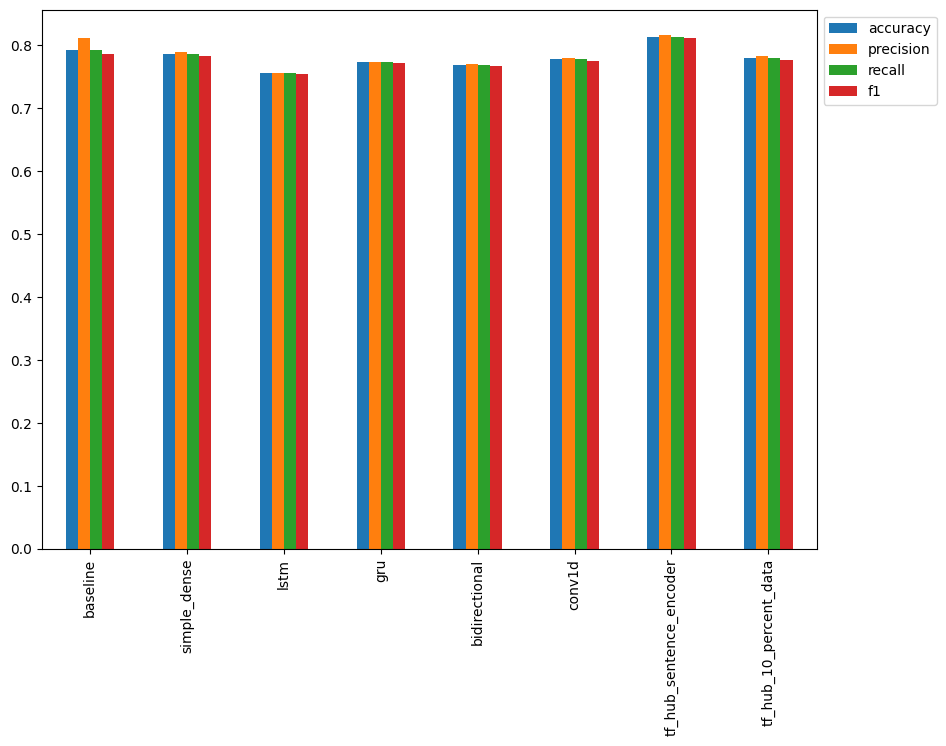

In [112]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

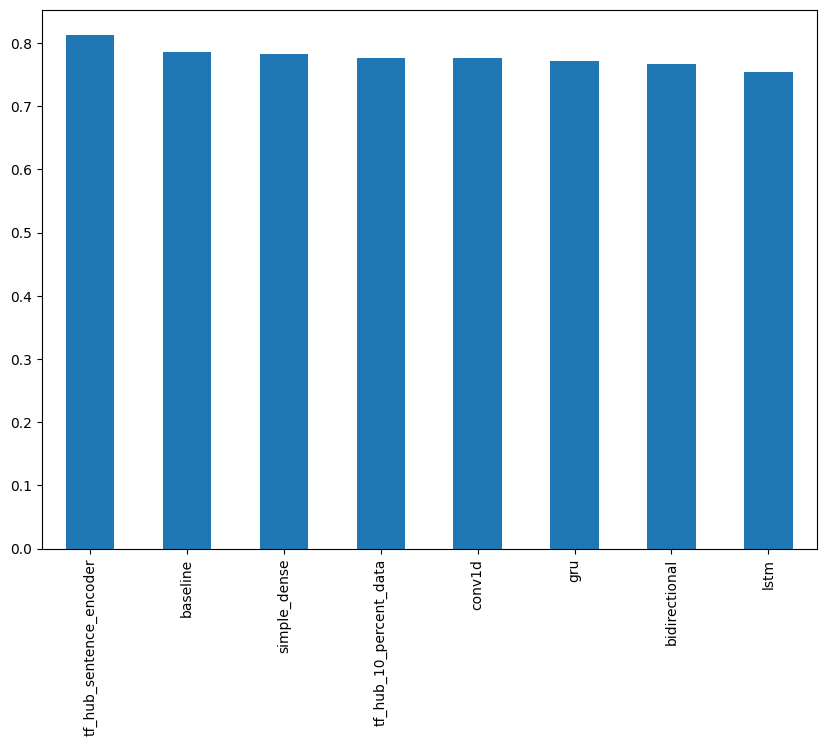

In [113]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In [ ]:
# # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs \
#   --name "NLP modelling experiments" \
#   --description "A series of different NLP modellings experiments with various models" \
#   --one_shot # exits the uploader when upload has finished

Daniel's: https://tensorboard.dev/experiment/LkoAakb7QIKBZ0RL97cXbw/

In [ ]:
# If you need to remove previous experiments, you can do so using the following command
# !tensorboard dev delete --experiment_id EXPERIMENT_ID_TO_DELETE

## Combining our models (model ensembling/stacking)

In [114]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [115]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 78.21522309711287,
 'precision': 0.7818350347652623,
 'recall': 0.7821522309711286,
 'f1': 0.7817273427680089}

In [116]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [118]:
# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.786089,0.790328,0.786089,0.783297
lstm,0.755906,0.756918,0.755906,0.753828
gru,0.772966,0.772943,0.772966,0.771969
bidirectional,0.769029,0.769927,0.769029,0.767309
conv1d,0.778215,0.780752,0.778215,0.775881
tf_hub_sentence_encoder,0.813648,0.816066,0.813648,0.812062
tf_hub_10_percent_data,0.779528,0.783701,0.779528,0.776576
ensemble_results,0.007822,0.781835,0.782152,0.781727


## Saving and loading a trained model

In [119]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [120]:
# Load model w/ custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [121]:
# How does our model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 22ms/step - loss: 0.4322 - accuracy: 0.8136


[0.43220505118370056, 0.8136482834815979]

In [122]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

In [123]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [124]:
# Evaluate loaded SavedModel format
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 24ms/step - loss: 0.4322 - accuracy: 0.8136


[0.43220505118370056, 0.8136482834815979]

## Finding the most wrong examples

In [125]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_probs": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_probs
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.156481
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.740287
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.985212
3,@camilacabello97 Internally and externally scr...,1,0.0,0.204436
4,Radiation emergency #preparedness starts with ...,1,1.0,0.728779


In [128]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_probs", ascending=False)
most_wrong[:10]

,text,target,pred,pred_probs
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.907976
759,FedEx will no longer transport bioterror patho...,0,1.0,0.853943
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.840674
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.840233
628,@noah_anyname That's where the concentration c...,0,1.0,0.828779
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.826171
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.782178
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.779979
144,The Sound of Arson,0,1.0,0.759162
567,@RebeccaforReal accepts Wisconsin Emergency Re...,0,1.0,0.759019


In [130]:
# Check the false positives (model predicted 1, when it should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9079756736755371
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8539426326751709
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8406742811203003
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Prob: 0.8402334451675415
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0.828778862953186
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8261709213256836
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1, Pro

In [132]:
# Check the most wrong false negatives (model predicted 0, when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.05969779193401337
Text:
@BoyInAHorsemask its a panda trapped in a dogs body

----

Target: 1, Pred: 0, Prob: 0.05461543798446655
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.053960539400577545
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.05291794240474701
Text:
VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP WATCH 241487 http://t.co/yFy3nkkcoH http://t.co/KNEhVvOHVK

----

Target: 1, Pred: 0, Prob: 0.0485677532851696
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.04443657398223877
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0, Prob: 0.037796132266521454
Text:
Reddit Will N

## Making predictions on the test dataset

In [133]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 63ms/step
Pred: 0, Prob: 0.036580152809619904
Text:
100  1' MIX NEW FLAT DOUBLE SIDED LINERLESS BOTTLE CAPS YOU CHOOSE MIX FLATTENED - Full reÛ_ http://t.co/61fALvOCuK http://t.co/1MuTpFcgDL

----

1/1 [==============================] - 0s 59ms/step
Pred: 0, Prob: 0.1792200356721878
Text:
Here we go....one more Toss with the Seismic boys! With a stellar undercard all killer no filler keep an eye... http://t.co/Xs6aa2c6Jb

----

1/1 [==============================] - 0s 50ms/step
Pred: 0, Prob: 0.09062478691339493
Text:
Keep up the great work Councilman Brian O'Neill http://t.co/ueS3IhSyIq

----

1/1 [==============================] - 0s 55ms/step
Pred: 0, Prob: 0.1055128276348114
Text:
@KimAcheson @ScottWalker / Emergency Room can not refuse you service &amp; you can do a payment plan.

----

1/1 [==============================] - 0s 71ms/step
Pred: 1, Prob: 0.897010326385498
Text:
30 Years After the Chernobyl Nuclear Disaster via @fubiz http:

## Predicting on Tweets from the wild

In [134]:
# Turn Tweet into string
daniels_tweet = "Life like an ensemble: take the best choices from others and make your own"

In [135]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.
  Returns the sentence, the predicted label, and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [136]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=daniels_tweet)

1/1 [==============================] - 0s 294ms/step
Pred: 0.0 (not real disaster) Prob: 0.04145347326993942
Text:
Life like an ensemble: take the best choices from others and make your own


In [137]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [138]:
# Predict on disaster Tweet 1
predict_on_sentence(model=model_6,
                    sentence=beirut_tweet_1)

1/1 [==============================] - 0s 88ms/step
Pred: 1.0 (real disaster) Prob: 0.9588451981544495
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [139]:
# Predict on disaster Tweet 2
predict_on_sentence(model=model_6,
                    sentence=beirut_tweet_2)

1/1 [==============================] - 0s 237ms/step
Pred: 1.0 (real disaster) Prob: 0.968938410282135
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


## The speed/score trade-off

In [140]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.

  Args:
  ----
  model = a trained model
  sample = a list of sanmples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [141]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 1s 28ms/step


(1.4024903640020057, 0.001840538535435703)

In [142]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.08484307799881208, 0.00011134262204568514)

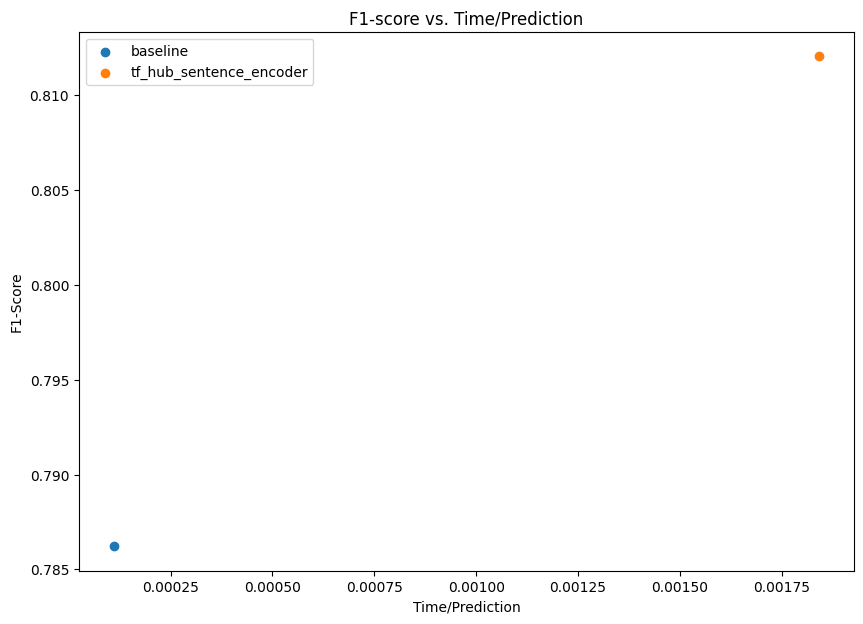

In [143]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score vs. Time/Prediction")
plt.xlabel("Time/Prediction")
plt.ylabel("F1-Score");